### Imports

In [27]:
import os
os.chdir('../../')

from hydra import initialize, compose
from omegaconf import OmegaConf

import mlflow
import pickle
import pandas as pd
import numpy as np
import wordcloud
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

### Load Trained Model

In [6]:
with initialize(version_base=None, config_path='../../conf/'):
    cfg = compose(config_name='config')
cfg = cfg.test
print(cfg)

{'mlflow_dir': 'mlruns', 'mlflow_source_experiment_name': 'hparam_simplification', 'mlflow_run_id': '8a2417c0ca784c12a4cccd8abca64a58', 'test_path': '${split_train_test.test_path}', 'target_var': 'Q2', 'mlflow_target_experiment_name': 'test'}


In [9]:
# Load the trained model
exper = mlflow.get_experiment_by_name(cfg.mlflow_source_experiment_name)
model_loc = f'{cfg.mlflow_dir}/{exper.experiment_id}/{cfg.mlflow_run_id}/artifacts/model/model.pkl'
with open(model_loc, 'rb') as f:
    mdl = pickle.load(f)

## ⚖️ Feature Weights

In [15]:
def get_feat_weights_df(mdl):
    coefs = mdl[-1].coef_.copy().flatten()
    feats = mdl[:-1].get_feature_names_out()
    return pd.DataFrame({
        'feature': [f.split('__')[1] for f in feats],
        'coef': coefs,
        'coef.abs': np.abs(coefs),
        'positive': [c >= 0 for c in coefs]
    })

feat_weights = get_feat_weights_df(mdl)
feat_weights = feat_weights.sort_values('coef')
feat_weights = feat_weights.set_index('feature')

### Words/Features Weighted *Toward* Q2 = 1

In [16]:
feat_weights.head(20)[['coef','coef.abs']]

,coef,coef.abs
feature,,
remember,-0.534491,0.534491
discuss,-0.412140,0.412140
improve,-0.311477,0.311477
prompt,-0.300444,0.300444
review,-0.284809,0.284809
continue,-0.282995,0.282995
suggest,-0.260139,0.260139
use,-0.219108,0.219108
overall,-0.200045,0.200045


### Words/Features Weighted *Against* Q2 = 1

In [17]:
feat_weights.tail(20)[['coef','coef.abs']]

,coef,coef.abs
feature,,
vec_79,0.116966,0.116966
vec_46,0.117150,0.117150
vec_63,0.119437,0.119437
arrange,0.120747,0.120747
vec_8,0.122221,0.122221
trainee able,0.122734,0.122734
receive,0.123895,0.123895
instruction,0.125415,0.125415
have,0.133132,0.133132


## ⚖️ ➖ Feature Weights (vector features removed)

In [33]:
feat_weights = feat_weights.reset_index()
feat_weights = feat_weights[~feat_weights['feature'].str.contains('vec_')].set_index('feature')

### Words/Features Weighted *Toward* Q2 = 1

In [ ]:
feat_weights.tail(20)[['coef','coef.abs']]

,coef,coef.abs
feature,,
vec_79,0.116966,0.116966
vec_46,0.117150,0.117150
vec_63,0.119437,0.119437
arrange,0.120747,0.120747
vec_8,0.122221,0.122221
trainee able,0.122734,0.122734
receive,0.123895,0.123895
instruction,0.125415,0.125415
have,0.133132,0.133132


### Words/Features Weighted *Against* Q2 = 1

In [ ]:
feat_weights.tail(20)[['coef','coef.abs']]

,coef,coef.abs
feature,,
vec_79,0.116966,0.116966
vec_46,0.117150,0.117150
vec_63,0.119437,0.119437
arrange,0.120747,0.120747
vec_8,0.122221,0.122221
trainee able,0.122734,0.122734
receive,0.123895,0.123895
instruction,0.125415,0.125415
have,0.133132,0.133132


## ☁️ Word Clouds

### All Words

Red means the word is weighted *toward* Q2 = 0

Green means the word is weighted *against* Q2 = 1

In [24]:
def color_func(word, *args, **kwargs):
    if not feat_weights.loc[word, 'positive']: return (60, 186, 72)
    else: return (186, 60, 60)

(-0.5, 799.5, 399.5, -0.5)

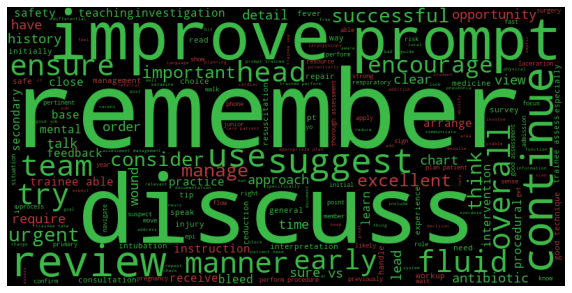

In [38]:
fw_for_wc = feat_weights[['coef.abs']].to_dict()['coef.abs']
wc = wordcloud.WordCloud(width=800, height=400, color_func=color_func)
wc = wc.fit_words(fw_for_wc)
plt.figure(figsize=(10,20))
plt.imshow(wc)
plt.axis('off')

### Wordcloud -  Words Weighted *Toward* Q2 = 1

(-0.5, 799.5, 399.5, -0.5)

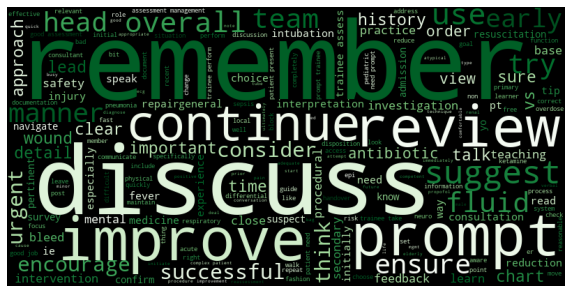

In [36]:
fw_for_wc = feat_weights[feat_weights['coef'] < 0][['coef.abs']].to_dict()['coef.abs']
wc = wordcloud.WordCloud(width=800, height=400, colormap=get_cmap('Greens'))
wc = wc.fit_words(fw_for_wc)
plt.figure(figsize=(10,20))
plt.imshow(wc)
plt.axis('off')

### Wordcloud -  Words Weighted *Against* Q2 = 1

(-0.5, 799.5, 399.5, -0.5)

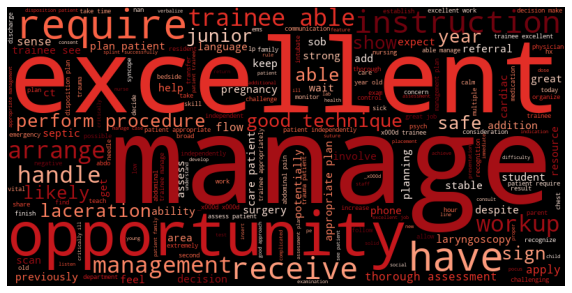

In [37]:
fw_for_wc = feat_weights[feat_weights['coef'] >= 0][['coef.abs']].to_dict()['coef.abs']
wc = wordcloud.WordCloud(width=800, height=400, colormap=get_cmap('Reds'))
wc = wc.fit_words(fw_for_wc)
plt.figure(figsize=(10,20))
plt.imshow(wc)
plt.axis('off')